<a href="https://colab.research.google.com/github/gtbnhyujmj2003/Cat-Dog-Classification/blob/master/%5BCatDog%5D%5B06%5D%20EfficientNet%20B0%20-%20%5BDense%20%3D%201%5D%5Bopt%20%3D%20Ranger%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
!pip install -U efficientnet

In [2]:
# 因為圖片實在太多，所以要用壓縮檔載入
import zipfile

f = zipfile.ZipFile("/content/drive/My Drive/CatDog/train.zip")
f.extractall("./datasets")

In [3]:
from glob import glob

# Cat = 0
catfs = glob("./datasets/train/cat.*.jpg")
catans = [0] * len(catfs)

# Dog = 1
dogfs = glob("datasets/train/dog.*.jpg")
dogans = [1] * len(dogfs)

In [4]:
# 製作表格
import pandas as pd

df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})

In [5]:
# 創造資料夾

import os

for class_num in range(2):
  DATASET_PATH_TRAIN = '/content/train_images/'

  # exist_ok：只有在目录不存在时创建目录，目录已存在时不会抛出异常。
  os.makedirs(DATASET_PATH_TRAIN + str(class_num), exist_ok=True)

In [6]:
# 移動檔案

import shutil

for class_num in range(2):
  class_list = df[df["target"] == class_num]["path"]

  for OldPath in class_list:
    name = OldPath.split("/")[-1]
    NewPath = '/content/train_images/' + str(class_num) + "/"
    
    shutil.move(OldPath, NewPath + str(name))

In [7]:
Size = 224

In [8]:
# Generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Generator = ImageDataGenerator(rescale= 1.0 / 255.0,
                               validation_split= 0.2)

In [9]:
TrainFlowGenerator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "binary", 
    subset= "training")

ValidFlowGenetator = Generator.flow_from_directory(
    directory= "/content/train_images/",
    target_size= (Size, Size),
    class_mode= "binary", 
    subset= "validation")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
import efficientnet.tfkeras as efn

from tensorflow.keras import Model
import tensorflow.keras.layers as L

System = efn.EfficientNetB0(input_shape = (Size, Size, 3),
                            weights = 'imagenet',
                            include_top = False)

for layer in System.layers[ :10]:
    layer.trainable = False

for layer in System.layers[10: ]:
    layer.trainable = True

x = System.output
x = L.GlobalMaxPooling2D()(x)
x = L.BatchNormalization()(x)
x = L.Dense(1, activation="selu")(x)
# x = L.Dropout(0.5)(x)
y = L.Dense(1, activation='sigmoid')(x)

model = Model(inputs= System.input, outputs= y)

In [11]:
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.optimizers import Lookahead
from tensorflow_addons.optimizers import RectifiedAdam

Radam = RectifiedAdam(lr= 1e-4)
Ranger = Lookahead(Radam, sync_period=6, slow_step_size=0.5)

model.compile(optimizer= Ranger,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(TrainFlowGenerator,
                    epochs=50, verbose=2,
                    validation_data= ValidFlowGenetator,
)

In [13]:
# 少用 Dense
# (Dense 512) 743/743 - 1087s - loss: 0.8883 - accuracy: 0.6062 - val_loss: 0.5847 - val_accuracy: 0.7112
# (Dense 001) 625/625 - -181s - loss: 0.3906 - accuracy: 0.8629 - val_loss: 0.2345 - val_accuracy: 0.9760
# 1087s 真是太久了。

# Flatten + Dense 可以用 Global Pooling 系列取代掉 by 尹相志

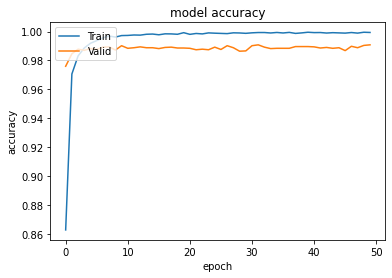

In [14]:
# accuracy

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['Train', 'Valid'], loc='upper left') 
plt.show()

In [15]:
# 載入 真．驗證資料
import zipfile

f = zipfile.ZipFile("./drive/My Drive/CatDog/test1.zip")
f.extractall("./datasets_test/")

In [16]:
TestFlowed = Generator.flow_from_directory(
    directory = "/content/datasets_test/",
    target_size= (Size, Size),
    class_mode= None,
    shuffle= False, 
    )

Found 12500 images belonging to 1 classes.


In [17]:
predict = model.predict(TestFlowed, verbose=1).argmax(axis=-1)

391/391 [==============================] - 47s 121ms/step
